In [64]:
# !pip install opendatasets

In [65]:
import opendatasets as od

# od.download('https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification')

In [66]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os

In [67]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Device using is : {device}")

Device using is : cuda


In [68]:
train_df = pd.read_csv('/content/bean-leaf-lesions-classification/train.csv')
val_df = pd.read_csv('/content/bean-leaf-lesions-classification/val.csv')

In [69]:
train_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + train_df["image:FILE"]
val_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + val_df["image:FILE"]


In [70]:
print(train_df.shape)
print(val_df.shape)

(1034, 2)
(133, 2)


In [71]:
train_df.head()

,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [72]:
val_df.head()

,image:FILE,category
0,/content/bean-leaf-lesions-classification/val/...,0
1,/content/bean-leaf-lesions-classification/val/...,0
2,/content/bean-leaf-lesions-classification/val/...,0
3,/content/bean-leaf-lesions-classification/val/...,0
4,/content/bean-leaf-lesions-classification/val/...,0


In [73]:
train_df['category'].unique()

array([0, 1, 2])

In [74]:
train_df['category'].value_counts()

,count
category,
2,348
1,345
0,341


In [75]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [76]:
class CustomDataset(Dataset):
  def __init__(self, df, transform):
    self.df = df
    self.transform = transform
    self.labels = torch.tensor(df['category']).to(device)

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
    image_path = self.df.iloc[idx, 0]
    label = self.labels[idx]

    image = Image.open(image_path).convert('RGB') # Ensure image is in RGB format

    if self.transform:
      image = (self.transform(image)/255).to(device)

    return image, label

In [77]:
train_dataset = CustomDataset(train_df, transform = transform)
val_dataset = CustomDataset(val_df, transform = transform)

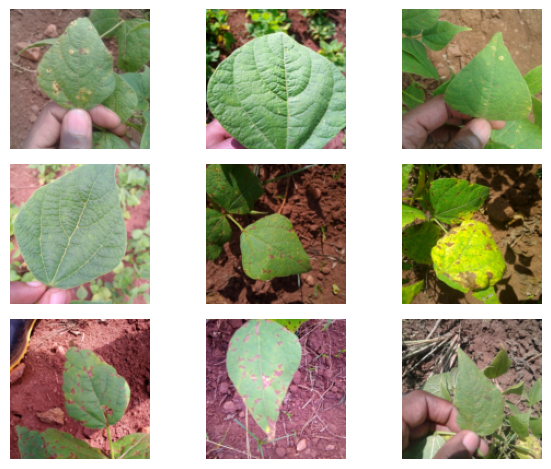

In [78]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
        image = train_dataset[np.random.randint(0,train_dataset.__len__())][0].cpu()
        axarr[row, col].imshow((image*255).squeeze().permute(1,2,0))
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()


In [79]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 20

In [80]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [81]:
googlenet_model = models.googlenet(weights='DEFAULT')

In [82]:
for param in googlenet_model.parameters():
  param.requires_grad = True

In [83]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [84]:
num_classes = len(train_df['category'].unique())
num_classes

3

In [85]:
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [86]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [87]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr=LR)

In [88]:
total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for (inputs, labels) in train_loader:
    optimizer.zero_grad()
    outputs = googlenet_model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))

  print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}%')
  print()

Epoch 1/20, Train Loss: 2.4425 Train Accuracy 55.8027%

Epoch 2/20, Train Loss: 2.1995 Train Accuracy 61.9923%

Epoch 3/20, Train Loss: 1.9818 Train Accuracy 67.2147%

Epoch 4/20, Train Loss: 1.7903 Train Accuracy 70.6963%

Epoch 5/20, Train Loss: 1.6753 Train Accuracy 73.2108%

Epoch 6/20, Train Loss: 1.6847 Train Accuracy 73.2108%

Epoch 7/20, Train Loss: 1.5219 Train Accuracy 76.3056%

Epoch 8/20, Train Loss: 1.4619 Train Accuracy 78.7234%

Epoch 9/20, Train Loss: 1.4715 Train Accuracy 78.4333%

Epoch 10/20, Train Loss: 1.3419 Train Accuracy 80.8511%

Epoch 11/20, Train Loss: 1.2406 Train Accuracy 82.4952%

Epoch 12/20, Train Loss: 1.0481 Train Accuracy 85.6867%

Epoch 13/20, Train Loss: 1.2942 Train Accuracy 80.4642%

Epoch 14/20, Train Loss: 0.9541 Train Accuracy 85.7834%

Epoch 15/20, Train Loss: 0.9825 Train Accuracy 86.4603%

Epoch 16/20, Train Loss: 0.8439 Train Accuracy 87.3308%

Epoch 17/20, Train Loss: 0.7839 Train Accuracy 88.3946%

Epoch 18/20, Train Loss: 0.6429 Train Ac

In [89]:
with torch.no_grad():
  total_loss_val = 0
  total_acc_val = 0
  for indx, (input, labels) in enumerate(val_loader):

    prediction = googlenet_model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_val += acc

print(f"Accuracy Score is: {round((total_acc_val/val_dataset.__len__())*100, 2)}%")

Accuracy Score is: 86.47%


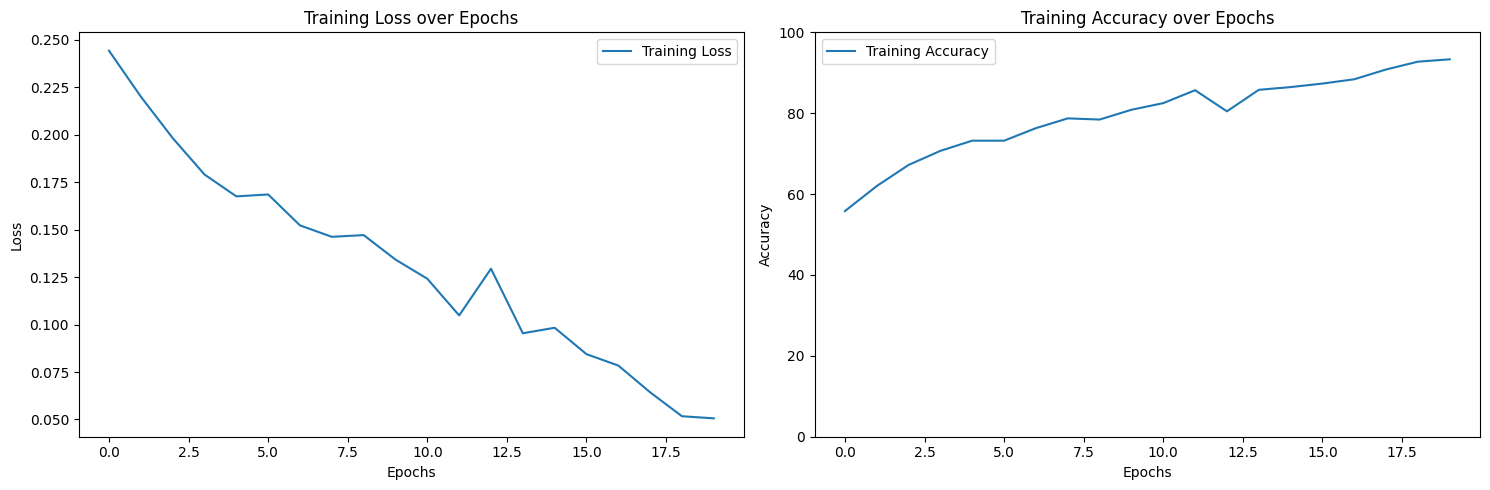

In [90]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

In [91]:
torch.save(googlenet_model.state_dict(), 'googlenet_model.pth')
print("Model saved successfully to googlenet_model.pth")

Model saved successfully to googlenet_model.pth
